In [1]:
# !apt-get update ; apt-get install -y graphviz libgraphviz-dev
# %pip install scikit_learn
# %pip install pydot
# %pip install pydotplus
# %pip install graphviz
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import tensorflow as tf
import random
from datetime import datetime
from tensorflow.keras.models import load_model

%matplotlib inline
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # do not use GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
# Attempt to make runs more reproducible
seed_value=20212042
print("Using seed value: %d" % seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value) # tensorflow 2.x

# Set paths
PRIZE_DATA = True
base_dir = "/workspace/C683_Assignment"
data_dir = os.path.join(base_dir, "prize-data" if PRIZE_DATA else "ml-100k")
movie_titles = os.path.join(data_dir, "movie_titles.csv")
model_filepath_tmpl = os.path.join(base_dir, "model-weights", "weights-%s-%s-%d-rmse%.04f-batch%d.h5")
all_data_filepath  = os.path.join(data_dir, "all_data.csv")
train_data_filepath  = os.path.join(data_dir, "train_data.pkl")
test_data_filepath = os.path.join(data_dir, "test_data.pkl")

# Utility classes / functions
def get_genres(titles):
    return [col for col in titles if col.startswith("genre.")]

class TrainTestSequence(keras.utils.Sequence):
    def __init__(self, data_set, titles, batch_size):
        self.data_set = data_set
        self.titles = titles
        self.genre_cols = get_genres(titles)
        self.batch_size = batch_size
        
    def __len__(self):
        return self.data_set.shape[0] // self.batch_size
    
    def __getitem__(self, idx):
        batch = self.data_set[idx*self.batch_size:(idx+1)*self.batch_size]
        rating_month = batch["date"].apply(lambda x: x.month / 12.)
        rating_monthday = batch["date"].apply(lambda x: x.day / 31.)
        rating_weekday = batch["date"].apply(lambda x: x.weekday() / 7.)
        batch = batch.merge(titles, how="inner", left_on="movie", right_on="id")
        return [np.array(batch["user_ord"]), np.array(batch["movie_ord"]), np.array(rating_month), np.array(rating_monthday), np.array(rating_weekday)], \
                np.array(batch["rating"])
    
def make_generator(data_set, titles, batch_size, worker_count, use_multiprocessing):
    seq = TrainTestSequence(data_set, titles, batch_size)
    enq = keras.utils.OrderedEnqueuer(seq, use_multiprocessing=use_multiprocessing)
    enq.start(workers=worker_count, max_queue_size=worker_count*20)
    return enq

Num GPUs Available: 1
Tensorflow version: 2.4.0
Using seed value: 20212042


In [2]:
# Constants
USER_COUNT = 480189 if PRIZE_DATA else 943
MOVIE_COUNT = 17770 if PRIZE_DATA else 1682
TRAIN_BATCH_SIZE = 512 if PRIZE_DATA else 32
TEST_BATCH_SIZE = 16384 if PRIZE_DATA else 256
MAX_YEAR = 2021
TRAIN_ITERATIONS_COUNT = 20
print("TRAIN_BATCH_SIZE: %d" % TRAIN_BATCH_SIZE)
print("TEST_BATCH_SIZE: %d" % TEST_BATCH_SIZE)
print("TRAIN_ITERATIONS_COUNT: %d" % TRAIN_ITERATIONS_COUNT)

# Prepare train/test if needed
if not os.path.isfile(train_data_filepath) or not os.path.isfile(test_data_filepath):
    all_data = None
    if PRIZE_DATA:
        print("Loading Netflix Prize data set")
        all_data = pd.read_csv(all_data_filepath,
                               names=[ "movie", "user", "rating", "date" ],
                               dtype={ "movie": np.int, "user": np.int, "movie": np.int },
                               parse_dates=["date"])
    else:
        all_data = pd.read_csv(all_data_filepath,
                               names=[ "user", "movie", "rating", "date" ],
                               dtype={ "movie": np.int, "user": np.int, "movie": np.int },
                               parse_dates=["date"],
                               sep="\t")
    print("Creating ordinal encodings for movie and user")
    ord_enc = OrdinalEncoder(dtype=np.int)
    all_data["movie_ord"] = ord_enc.fit_transform(all_data[["movie"]])
    all_data["user_ord"] = ord_enc.fit_transform(all_data[["user"]])
    print(all_data.head())
    print("Splitting into train and test data")
    train_data, test_data = train_test_split(all_data, test_size=0.15)
    print("Writing train data to a file")
    train_data.to_pickle(train_data_filepath)
    print("Writing test data to a file")
    test_data.to_pickle(test_data_filepath)
else:
    print("Loading Prize train data")
    train_data = pd.read_pickle(train_data_filepath)
    print("Loading Prize test data")
    test_data = pd.read_pickle(test_data_filepath)
    
display(train_data.head())
train_batch_count = train_data.shape[0] // TRAIN_BATCH_SIZE
steps_per_epoch = train_batch_count//(1000 if PRIZE_DATA else 20)
display(test_data.head())
test_batch_count = test_data.shape[0] // TEST_BATCH_SIZE

print("Loading movie titles")
titles = None
if PRIZE_DATA:
    titles = pd.read_csv(movie_titles)
else:
    titles = pd.read_csv(movie_titles,
                   names=[ "id", "title", "release", "video_release", "url",
                          "genre.unknown", "genre.Action", "genre.Adventure", "genre.Animation", "genre.Children's",
                          "genre.Comedy", "genre.Crime", "genre.Documentary", "genre.Drama", "genre.Fantasy",
                          "genre.Film-Noir", "genre.Horror", "genre.Musical", "genre.Mystery", "genre.Romance", "genre.Sci-Fi",
                          "genre.Thriller", "genre.War", "genre.Western" ],
                   parse_dates=["release"],
                   sep="|")
    titles = titles.dropna(subset=["release"])
    titles["year"] = titles["release"].apply(lambda x: int(x.year))
display(titles.head())

TRAIN_BATCH_SIZE: 512
TEST_BATCH_SIZE: 16384
TRAIN_ITERATIONS_COUNT: 20
Loading Prize train data
Loading Prize test data


,movie,user,rating,date,movie_ord,user_ord
38480499,6844,1494197,5,2005-03-27,6843,271046
87789839,15582,1172390,4,2003-06-30,15581,212778
19259747,3650,1074718,4,2005-09-24,3649,195221
74133544,13437,1989902,5,2005-11-09,13436,360811
55007458,10042,1397482,5,2005-06-22,10041,253596


,movie,user,rating,date,movie_ord,user_ord
92940674,16452,278913,3,2004-06-04,16451,50646
48329141,8707,158701,5,2005-07-25,8706,28765
73583996,13359,1521001,4,2004-02-16,13358,276042
59080189,10852,156276,4,2005-02-07,10851,28307
90883569,16175,531368,3,2003-03-05,16174,96601


Loading movie titles


,Unnamed: 0,Unnamed: 0.1,id,year,title,id_moviedb,genre_ids,vote_average,media_type,popularity,...,genre.Romance,genre.Fantasy,genre.Family,genre.Crime,genre.Drama,genre.Music,genre.History,genre.TV Movie,genre.War,genre.Western
0,0,0,17,2005,7 Seconds,9721,"[28, 80, 53]",5,movie,12.895,...,0,0,0,1,0,0,0,0,0,0
1,1,1,85,2005,Elfen Lied,550300,"[28, 16, 18, 27, 10749, 878]",7,movie,2.681,...,1,0,0,0,1,0,0,0,0,0
2,2,2,91,2005,WWE: Royal Rumble 2005,58649,"[28, 18]",7,movie,11.739,...,0,0,0,0,1,0,0,0,0,0
3,3,3,149,2005,The Edward R. Murrow Collection,0,NaN,0,unknown,0.000,...,0,0,0,0,0,0,0,0,0,0
4,4,4,151,2005,Sleepover Nightmare,13568,[27],3,movie,6.800,...,0,0,0,0,0,0,0,0,0,0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Rating_Month (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Rating_Day_of_Month (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
Rating_Day_of_Week (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
Rating_Month_Dense_32 (Dense)   (None, 32)           64          Rating_Month[0][0]               
______________________________________________________________________________________________

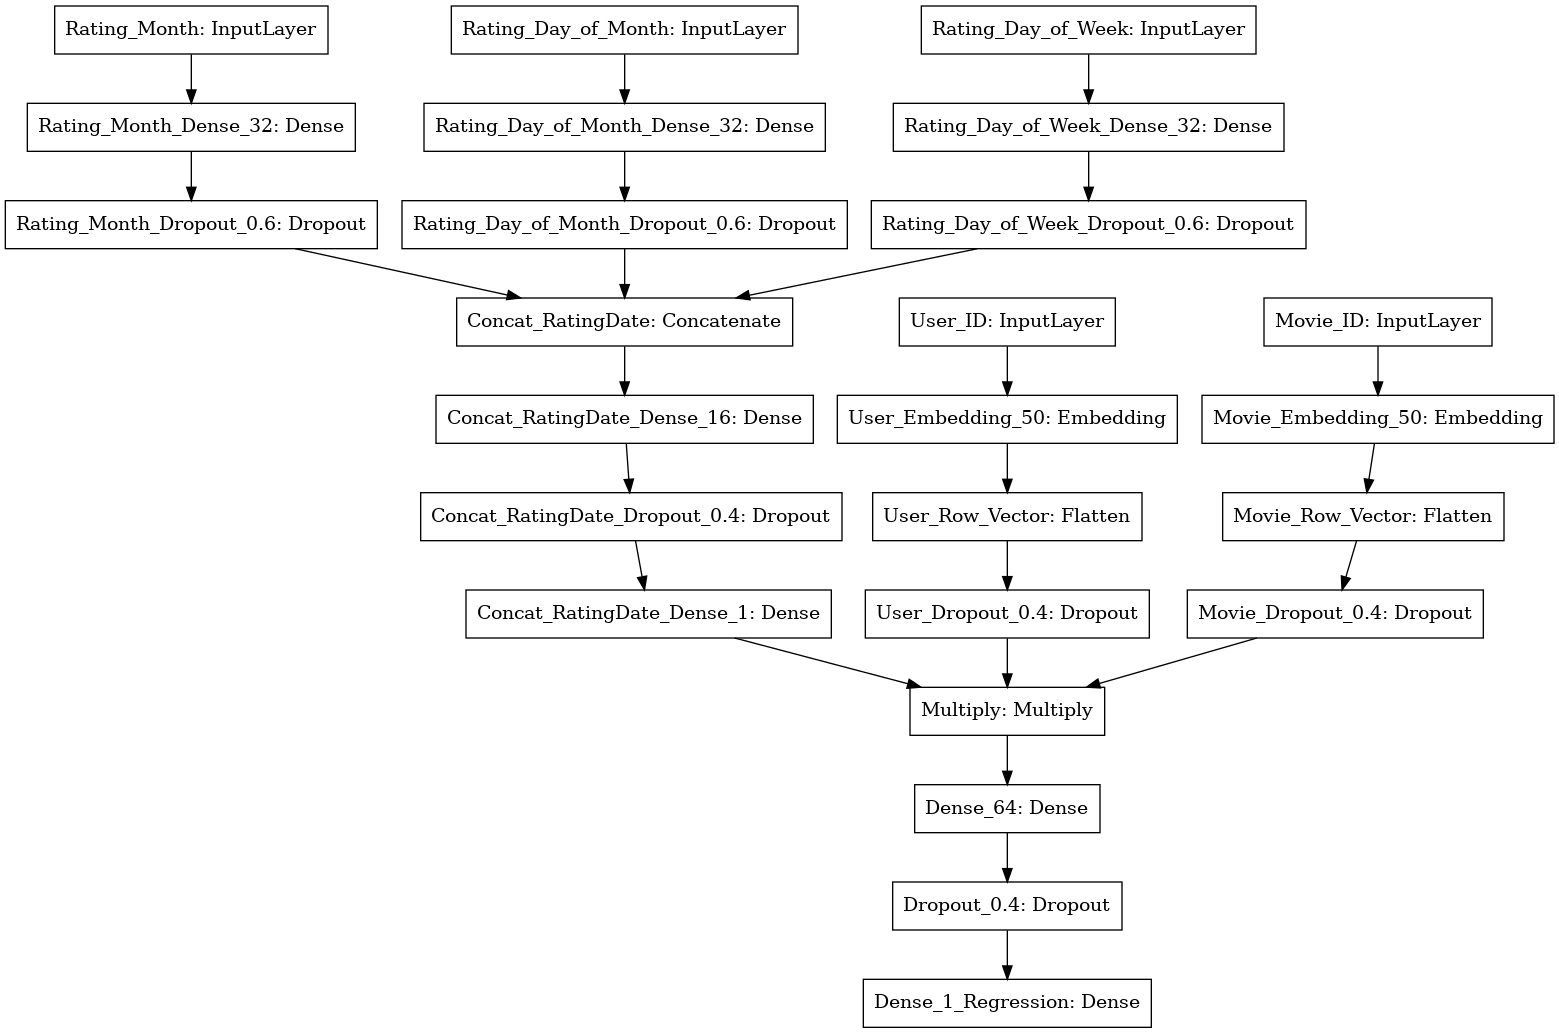

In [3]:
# Define model
user_input = keras.layers.Input(shape=(1,), name="User_ID")
user_embedding = keras.layers.Embedding(USER_COUNT, 96, name="User_Embedding_50")(user_input)
user_embedding = keras.layers.Flatten(name="User_Row_Vector")(user_embedding)
user_embedding = keras.layers.Dropout(0.4, name="User_Dropout_0.4")(user_embedding)

movie_input = keras.layers.Input(shape=(1,), name="Movie_ID")
movie_embedding = keras.layers.Embedding(MOVIE_COUNT, 96, name="Movie_Embedding_50")(movie_input)
movie_embedding = keras.layers.Flatten(name="Movie_Row_Vector")(movie_embedding)
movie_embedding = keras.layers.Dropout(0.4, name="Movie_Dropout_0.4")(movie_embedding)

month_input = keras.layers.Input(shape=(1,), name="Rating_Month")
month_dense = keras.layers.Dense(32, name="Rating_Month_Dense_32")(month_input)
month_dense = keras.layers.Dropout(0.6, name="Rating_Month_Dropout_0.6")(month_dense)

monthday_input = keras.layers.Input(shape=(1,), name="Rating_Day_of_Month")
monthday_dense = keras.layers.Dense(32, name="Rating_Day_of_Month_Dense_32")(monthday_input)
monthday_dense = keras.layers.Dropout(0.6, name="Rating_Day_of_Month_Dropout_0.6")(monthday_dense)

weekday_input = keras.layers.Input(shape=(1,), name="Rating_Day_of_Week")
weekday_dense = keras.layers.Dense(32, name="Rating_Day_of_Week_Dense_32")(weekday_input)
weekday_dense = keras.layers.Dropout(0.6, name="Rating_Day_of_Week_Dropout_0.6")(weekday_dense)

rating = keras.layers.Concatenate(name="Concat_RatingDate")([month_dense, monthday_dense, weekday_dense])
rating = keras.layers.Dense(96, name="Concat_RatingDate_Dense_16")(rating)
rating = keras.layers.Dropout(0.4, name="Concat_RatingDate_Dropout_0.4")(rating)
rating = keras.layers.Dense(1, name="Concat_RatingDate_Dense_1")(rating)

nn = keras.layers.Multiply(name="Multiply")([user_embedding, movie_embedding, rating])
nn = keras.layers.Dense(64, name="Dense_64")(nn)
nn = keras.layers.Dropout(0.4, name="Dropout_0.4")(nn)
nn = keras.layers.Dense(1, name="Dense_1_Regression")(nn)
model = keras.models.Model([user_input, movie_input, month_input, monthday_input, weekday_input], nn)
print(model.summary())
display(keras.utils.plot_model(model))

In [4]:
# Train model
optimizer = keras.optimizers.Adam(learning_rate=0.005 if PRIZE_DATA else 0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=keras.metrics.RootMeanSquaredError())
train_generator = make_generator(train_data, titles, TRAIN_BATCH_SIZE, 6, True).get()
evaluate_generator = make_generator(test_data, titles, TEST_BATCH_SIZE, 6, True)
for i in range(TRAIN_ITERATIONS_COUNT):
    model.fit(train_generator,
              epochs=1, steps_per_epoch=steps_per_epoch,
              verbose=1)

    # Evaluate and model
    y_pred = model.predict(evaluate_generator.get(), steps=test_batch_count, verbose=1)
    evaluate_generator.stop()
    evaluate_generator.start(workers=6, max_queue_size=1)
    rmse = mean_squared_error(test_data[:y_pred.shape[0]]["rating"], y_pred)
    print("RMSE: %.04f" % rmse)
    
model_filepath = model_filepath_tmpl % ("prize" if PRIZE_DATA else "ml100k", datetime.now().strftime("%d_%m_%Y_%H_%M"), 0, rmse, TRAIN_BATCH_SIZE)
model.save(model_filepath)

919/919 [==============================] - 55s 59ms/step
RMSE: 1.1784
919/919 [==============================] - 117s 128ms/step
RMSE: 1.1780
 10/166 [>.............................] - ETA: 1:46 - loss: 1.3214 - root_mean_squared_error: 1.1495

Process Keras_worker_ForkPoolWorker-32:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process Keras_worker_ForkPoolWorker-31:
Process Keras_worker_ForkPoolWorker-36:
Process Keras_worker_ForkPoolWorker-34:
Process Keras_worker_ForkPoolWorker-35:
Process Keras_worker_ForkPoolWorker-3:
Process Keras_worker_ForkPoolWorker-9:
Process Keras_worker_ForkPoolWorker-5:
Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-11:
Process Keras_worker_ForkPoolWorker-33:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/mult

 11/166 [>.............................]

  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__


KeyboardInterrupt: 